## The nugget effect

The nugget effect in kriging is a source of misunderstanding and misinterpretation. In this notebook we therefore present an example of multiple ways to interpret and include a nugget effect in a kriging analysis and specifiy the method used in the GemPy. 
<br>
<br>
In literature the nugget effect is often subdivided into two different phenomena:
<br>
<br>
1) **Microscale variation** (or "True nugget effect"): This describes real geological microscale variations (as in gold nuggets, hence the name). It can be interpreted as a second variogram (meaning a second scale of spatial correlation) with a very small range compared to the general scale of spatial correlation. Therefore it also includes variation below the resolution of the measurements e.g. the closest distance between measurement locations. 
<br>
<br>
2) **Measurement error:** (or "Noise"/"Human nugget effect"). This includes measurement errors occuring from either sampling or assaying. It thus covers a subscale variance that is inherent to the wohle dataset.
<br>
<br>
The big difference between those interpretations lies in how they treat the origin of the variogram. In case of a pure nugget effect, gamma(0) = 0 by definiton. This causes the nested variogram (exponential variogram plus nugget variogram) to be discontinous at the origin. It also ensures that kriging stays an exact interpolator, meaning that if you estiamte at a location where data is available, it will take this exact value.

If we consider the nugget effect to be noise from imprecise measurements, this means that estimates are allowed to deviate from measurements at same locations (as there might be a measurement error) and kriging stops being an exact interpolator.


Kriging functions:

In [1]:
# Importing auxiliary libraries
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
import pandas as pd

In [2]:
def exponential_variogram_model(d, range_, sill, nugget):
    psill = sill - nugget
    gamma = psill * (1. - np.exp(-(np.absolute(d) / (range_)))) + nugget

    return gamma

def exponential_covariance_model(d, range_, sill, nugget):
    psill = sill - nugget
    cov = psill * (np.exp(-(np.absolute(d) / (range_))))
    
    return cov


In [3]:
d_plot = np.arange(0,50,1)

vario_plot1 = exponential_variogram_model(d_plot, 5,5,1)
cov_plot1 = exponential_covariance_model(d_plot,5,5,1)

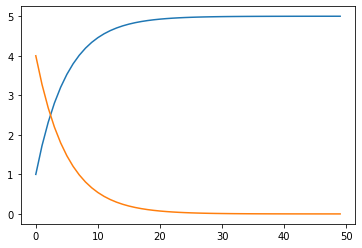

In [4]:
plt.plot(d_plot, vario_plot1)
plt.plot(d_plot, cov_plot1)

In [5]:
def kriging_1D(krig_locs, data, range_, sill, nugget, nugget_type='pure'): 
    # empty arrays for results (estimated values and variances)
    kriging_result_vals = np.zeros(len(krig_locs))
    kriging_result_vars = np.zeros(len(krig_locs))
    
    # calculate distances between all input data points
    dist_all_to_all = np.zeros((len(data), len(data)))
    for i in range(len(data)):
        dist_all_to_all[:,i] = np.absolute(data[:, 0]-data[i, 0])
    
    dist_grid_to_all = np.zeros((len(krig_locs), len(data)))
    for i in range(len(krig_locs)):
        dist_grid_to_all[i,:] = np.absolute(data[:, 0]-krig_locs[i])
    # calculate distances between all grid points and all input data point)
                                            
    # Main loop that goes through whole domain (grid)
    for i in range(len(krig_locs)):

        # STEP 1: Multiple if elif conditions to define moving neighbourhood:
        a = dist_grid_to_all[i]
        b = dist_all_to_all
        prop = data[:, 1]
        # STEP 2: Multiple if elif conditions to calculate kriging at point
        val, var = ordinary_kriging(a, b, prop,range_, sill,nugget, nugget_effect=nugget_type)
        # STEP 3: Save results
        kriging_result_vals[i] = val
        kriging_result_vars[i] = var
        # create dataframe of results data for calling
        d = {'X_loc': krig_locs, 'est_value': kriging_result_vals, 'est_variance': kriging_result_vars}
        results_df = pd.DataFrame(data=d)
        
    return results_df
    
def ordinary_kriging(b, a, prop, range_, sill, nugget, nugget_effect):
        # empty matrix building for OK
        shape = len(a)
        C = np.zeros((shape + 1, shape + 1))
        c = np.zeros((shape + 1))
        w = np.zeros((shape + 1))
        # filling matirces based on model for spatial correlation
        
        C[:shape, :shape] = exponential_variogram_model(a,range_,sill,nugget)
        c[:shape] = exponential_variogram_model(b,range_,sill,nugget)
        
        np.fill_diagonal(C, 0)
        
        if nugget_effect == 'exact':
            c[c==nugget]=0
        
        # matrix setup - compare pykrige, special for OK
        C[shape, :] = 1.0
        C[:, shape] = 1.0
        C[shape, shape] = 0.0
        c[shape] = 1.0
    
        w = np.linalg.solve(C, c)
    
        # calculating estimate and variance for kriging, variance is weird
        pred_var = w[shape] + np.sum(w[:shape] * c[:shape])
        
        if nugget_effect == 'filtered':
            pred_var = pred_var-nugget
        
        #result = np.sum(w[:shape] * prop)
        result = np.dot(prop, w[:shape])
        
        return result, pred_var

In [6]:
# set locations (grid equivalent) and input data as in literature example

locs = np.arange(0,3,0.1)
inp = np.array([[1,-1],[2,1]])


In [7]:
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual

In [8]:
def compare(r, s, n):

    results_df1 = kriging_1D(locs, inp, range_=r, sill=s, nugget=n, nugget_type='exact')
    loc1 = results_df1['X_loc'].values
    val1 = results_df1['est_value'].values
    var1 = results_df1['est_variance']
    
    results_df2 = kriging_1D(locs, inp, range_=r, sill=s, nugget=n, nugget_type='new_value')
    loc2 = results_df2['X_loc'].values
    val2 = results_df2['est_value'].values
    var2 = results_df2['est_variance']
    
    results_df3 = kriging_1D(locs, inp, range_=r, sill=s, nugget=n, nugget_type='filtered')
    loc3 = results_df3['X_loc'].values
    val3 = results_df3['est_value'].values
    var3 = results_df3['est_variance']

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 4))
    
    axes[0].plot(inp[:,0], inp[:,1], 's', markersize=10, fillstyle='none', color='black', label='data value')
    axes[0].plot(loc1, val1, '-o', label='exact')
    axes[0].plot(loc2, val2, '-o', markersize=3, label='new value/filtered')
    axes[0].set_ylim(-1.5,1.5)
    axes[0].legend()
    
    axes[1].set_ylim(0,1.5)
    axes[1].plot(loc1, np.sqrt(np.round(var1,2)))
    
    axes[1].plot(loc2, np.sqrt(var2))
    
    axes[1].plot(loc3, np.sqrt(var3)) 
    
    
    #axes[1].plot(loc2, np.sqrt(var2))

In [9]:
interact(compare, r=(1,11,1), s=(0.5,1.5,0.1), n=(0,1,0.1));

interactive(children=(IntSlider(value=6, description='r', max=11, min=1), FloatSlider(value=1.0, description='…

Part microscale, part pure

Krivoruchko, K., A. Gribov, and J. M. Ver Hoef, 2006,
A new method for handling the nugget effect in
kriging, in T. C. Coburn, J. M. Yarus, and R. L.
Chambers, eds., Stochastic modeling and geosta-
tistics: Principles, methods, and case studies, vol-
ume II: AAPG Computer Applications in Geology 5,
p. 81–89